In [3]:
import scipy.io as scio
import numpy as np    
import matplotlib.pyplot as plt
import sys
import os
import math
import pprint
import cv2
from scipy.misc import imsave
from helper import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
# plt.rcParams['image.cmap'] = 'gray'

In [4]:
import keras
from keras.layers import Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import UpSampling2D
from keras.layers import Concatenate
from keras.layers import Lambda 
from keras.utils import to_categorical
import tensorflow as tf

from keras.layers import Reshape

from keras import backend as K
from keras import regularizers, optimizers
%matplotlib inline

ModuleNotFoundError: No module named 'keras'

In [5]:
from keras.callbacks import ReduceLROnPlateau, CSVLogger,EarlyStopping,ModelCheckpoint

ModuleNotFoundError: No module named 'keras'

In [6]:
import scipy.io as scio
import numpy as np    
import os
import matplotlib.pyplot as plt
import math
import re
from scipy.misc import imsave
from scipy import ndimage, misc
from numpy import unravel_index
from operator import sub

In [7]:
def atoi(text) : 
    return int(text) if text.isdigit() else text

In [8]:
def natural_keys(text) :
    return [atoi(c) for c in re.split('(\d+)', text)]

In [9]:
def get_info(filenames, ext):
    images = []

    for filename in filenames :
        filepath = os.path.join(root,filename)
        if ext == '.npy':
            image = np.load(filepath)
            h,w = image.shape
            
            if h != 512 or w != 64:
#                 print(h,w) 
                amount = 512 - h
                id_full = np.full((amount, 64), 0)
                try:
                    image = np.concatenate((image, id_full))
                except Exception as e:
                    print(image.shape)
#                 print(image.shape)
        elif ext == '.JPG' or ext == '.png':
            image = ndimage.imread(filepath)
        images.append(image)
    return images

In [10]:
# Getting Raw Images
root_path = ""
filenames = []
for root, dirnames, filenames in os.walk("/home/sim/notebooks/relaynet_pytorch/datasets/OCTData/alldata/whole_raw_image/Train"):
    filenames.sort(key = natural_keys)
    rootpath = root
print(len(filenames))

0


In [11]:
print(filenames[128])

IndexError: list index out of range

In [12]:
raw_images = get_info(filenames, '.png')

In [13]:
plt.imshow(raw_images[0],cmap = "gray")

IndexError: list index out of range

In [12]:
print (raw_images[0].shape)

(512, 64)


In [13]:
# Getting manual labelled Images
root_path = ""
filenames = []
for root, dirnames, filenames in os.walk("/home/sim/notebooks/relaynet_pytorch/datasets/OCTData/alldata/manual_label/Train"):
    filenames.sort(key = natural_keys)
    rootpath = root
print(len(filenames))

600


In [14]:
manual_labels = get_info(filenames, '.png')
print (manual_labels[0].shape)

(512, 64, 3)


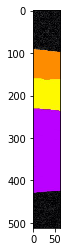

In [15]:
plt.imshow(manual_labels[0])

In [16]:
# Getting Labels
root_path = ""
filenames = []
# for root, dirnames, filenames in os.walk("/home/sim/notebooks/relaynet_pytorch/datasets/OCTData/alldata/labels_corrected/Train/segmented_ids"):
for root, dirnames, filenames in os.walk("/home/sim/notebooks/relaynet_pytorch/datasets/OCTData/alldata/png_labels_method/Train/segmented_ids"):
    filenames.sort(key = natural_keys)
    rootpath = root
# print(len(filenames))
labels_list = get_info(filenames, '.npy')
print(labels_list[0].shape)

(512, 64)


In [17]:
for ids in labels_list:
    h,w = ids.shape
    if h != 512 or w != 64:
        print(h,w)
print(np.unique(labels_list))

[ 0.  1.  2.  3.  4.  5.  6.  7.]


In [18]:
train_labels = np.zeros((len(filenames),512,64,8))
# train_labels = np.full((171,512,64,8),0.000
print(train_labels.shape)

(600, 512, 64, 8)


In [19]:
val = 1
for i in range(len(labels_list)) :
    for j in range(512) :
        for k in range(64):
            if(labels_list[i][j][k] == 0):
                train_labels[i][j][k][0] = val
            if(labels_list[i][j][k] == 1):
                train_labels[i][j][k][1] = val
            if(labels_list[i][j][k] == 2):
                train_labels[i][j][k][2] = val
            if(labels_list[i][j][k] == 3):
                train_labels[i][j][k][3] = val
            if(labels_list[i][j][k] == 4):
                train_labels[i][j][k][4] = val
            if(labels_list[i][j][k] == 5):
                train_labels[i][j][k][5] = val
            if(labels_list[i][j][k] == 6):
                train_labels[i][j][k][6] = val
            if(labels_list[i][j][k] == 7):
                train_labels[i][j][k][7] = val

In [20]:
train_labels.shape

(600, 512, 64, 8)

In [21]:
train_labels[0][0][0]

array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [22]:
images=raw_images
images=np.array(images)
print(images.shape[0])
images = images.reshape(images.shape[0],512,64,1)

num_files = len(filenames)
validation_cutoff = int(len(filenames)*0.8)

# print(images[0].shape)
train_indices = np.random.choice(num_files,validation_cutoff,replace = False)
# print(train_indices)
# print(sorted(train_indices))
# print(train_labels[170])

600


In [23]:
# print(train_indices)

In [24]:
train_images_random = []
train_labels_random = []

for i in train_indices:
    train_images_random.append(images[i])
    train_labels_random.append(train_labels[i])


In [25]:
test_indices = [x for x in range(num_files) if x not in train_indices]
print(test_indices)
test_images = []
test_labels = []

for i in test_indices:
    test_images.append(images[i])
    test_labels.append(train_labels[i])


[3, 5, 11, 16, 17, 19, 20, 23, 24, 25, 35, 38, 59, 62, 67, 72, 76, 79, 80, 82, 84, 95, 97, 100, 110, 114, 116, 117, 118, 119, 120, 122, 123, 124, 132, 141, 152, 159, 165, 167, 169, 170, 179, 183, 195, 199, 212, 217, 222, 224, 227, 233, 236, 243, 244, 246, 256, 265, 267, 270, 273, 277, 280, 284, 291, 295, 298, 308, 309, 312, 322, 326, 330, 335, 340, 344, 347, 351, 355, 358, 359, 367, 372, 376, 377, 379, 388, 389, 403, 409, 428, 431, 441, 443, 450, 461, 470, 479, 492, 496, 498, 499, 504, 512, 515, 519, 522, 527, 531, 534, 535, 538, 548, 554, 557, 558, 567, 581, 589, 593]


In [26]:
train_images = np.array(train_images_random)
train_labels = np.array(train_labels_random)
test_images = np.array(test_images)
test_labels = np.array(test_labels)

print(train_images.shape, test_images.shape)
print(train_labels.shape, test_labels.shape)


(480, 512, 64, 1) (120, 512, 64, 1)
(480, 512, 64, 8) (120, 512, 64, 8)


In [27]:
train_images = train_images.astype('float32')
train_labels = train_labels.astype('float32')
test_images = test_images.astype('float32')
test_labels = test_labels.astype('float32')


In [28]:
print(train_images.shape)
print(test_images.shape)
print(test_labels.shape)

(480, 512, 64, 1)
(120, 512, 64, 1)
(120, 512, 64, 8)


In [29]:
print(np.unique(train_images[0]))

[   0.    6.   11.   17.   23.   28.   34.   40.   45.   51.   57.   62.
   68.   74.   79.   85.   91.   96.  102.  108.  113.  119.  125.  130.
  136.  142.  147.  153.  159.  164.  170.  255.]


In [30]:
print (len(train_images))
print (len(train_labels))
print (np.array(train_labels).shape)

480
480
(480, 512, 64, 8)


In [31]:
train_images.shape

(480, 512, 64, 1)

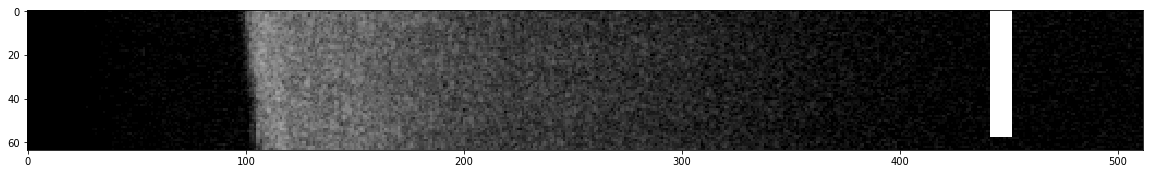

In [32]:
plt.figure(figsize=(20,10))
plt.imshow(np.rot90(train_images[0,:,:,0]), cmap=plt.cm.gray)

In [33]:
root_path = ""
filenames = []
# for root, dirnames, filenames in os.walk("/home/sim/notebooks/relaynet_pytorch/datasets/OCTData/alldata/labels_corrected/Train/weights"):
for root, dirnames, filenames in os.walk("/home/sim/notebooks/relaynet_pytorch/datasets/OCTData/alldata/png_labels_method/Train/weights"):
    filenames.sort(key = natural_keys)
    rootpath = root

weights = get_info(filenames, '.npy')

In [34]:
print(len(weights),weights[0].shape)

600 (512, 64)


In [35]:
print(weights[0][0][0])

1.0


In [36]:
np.unique(weights)

array([  1.,   6.,   7.,   9.,  11.,  16.,  17.,  19.,  21.,  26.])

In [37]:
weights_matrix = []
for i in train_indices:
    weights_matrix.append(weights[i])

In [38]:
len(weights_matrix)

480

In [39]:
sample_weights = np.array(weights_matrix)

In [40]:
data_shape = 512*64

In [41]:
sample_weights = np.reshape(sample_weights,(validation_cutoff,data_shape))

In [42]:
sample_weights.shape

(480, 32768)

In [43]:
weight_decay = 0.0001

In [44]:
# Defines the input tensor
inputs = Input(shape=(512,64,1))

L1 = Conv2D(64,kernel_size=(3,3),padding = "same",kernel_regularizer=regularizers.l2(weight_decay))(inputs)
L2 = BatchNormalization()(L1)
L2 = Activation('relu')(L2)
#L3 = Lambda(maxpool_1,output_shape = shape)(L2)
L3 = MaxPooling2D(pool_size=(2,2))(L2)
L4 = Conv2D(64,kernel_size=(3,3),padding = "same",kernel_regularizer=regularizers.l2(weight_decay))(L3)
L5 = BatchNormalization()(L4)
L5 = Activation('relu')(L5)
#L6 = Lambda(maxpool_2,output_shape = shape)(L5)
L6 = MaxPooling2D(pool_size=(2,2))(L5)
L7 = Conv2D(64,kernel_size=(3,3),padding = "same",kernel_regularizer=regularizers.l2(weight_decay))(L6)
L8 = BatchNormalization()(L7)
L8 = Activation('relu')(L8)
#L9 = Lambda(maxpool_3,output_shape = shape)(L8)
L9 = MaxPooling2D(pool_size=(2,2))(L8)
L10 = Conv2D(64,kernel_size=(3,3),padding = "same",kernel_regularizer=regularizers.l2(weight_decay))(L9)
L11 = BatchNormalization()(L10)
L11 = Activation('relu')(L11)
L12 = UpSampling2D(size = (2,2))(L11)
#L12 = Lambda(unpool_3,output_shape = unpool_shape)(L11)
L13 = Concatenate(axis = 3)([L8,L12])
L14 = Conv2D(64,kernel_size=(3,3),padding = "same",kernel_regularizer=regularizers.l2(weight_decay))(L13)
L15 = BatchNormalization()(L14)
L15 = Activation('relu')(L15)
L16 = UpSampling2D(size= (2,2))(L15)
#L16 = Lambda(unpool_2,output_shape=unpool_shape)(L15)
L17 = Concatenate(axis = 3)([L16,L5])
L18 = Conv2D(64,kernel_size=(3,3),padding = "same",kernel_regularizer=regularizers.l2(weight_decay))(L17)
L19 = BatchNormalization()(L18)
L19 = Activation('relu')(L19)
#L20 = Lambda(unpool_1,output_shape=unpool_shape)(L19)
L20 = UpSampling2D(size=(2,2),name = "Layer19")(L19)
L21 = Concatenate(axis=3)([L20,L2])
L22 = Conv2D(64,kernel_size=(3,3),padding = "same",kernel_regularizer=regularizers.l2(weight_decay))(L21)
L23 = BatchNormalization()(L22)
L23 = Activation('relu')(L23)
L24 = Conv2D(8,kernel_size=(1,1),padding = "same",kernel_regularizer=regularizers.l2(weight_decay))(L23)
L = Reshape((data_shape,8),input_shape = (512,64,8))(L24)
L = Activation('softmax')(L)
model = Model(inputs = inputs, outputs = L)
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 512, 64, 1)    0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 512, 64, 64)   640         input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 512, 64, 64)   256         conv2d_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 512, 64, 64)   0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

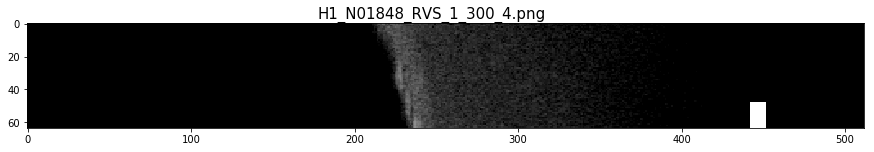

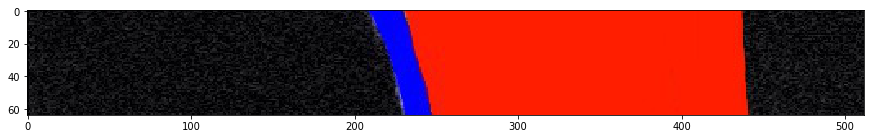

In [91]:
# # (512, 600)
# # 0 black
# # 1 red
# # 2 blue
# # 3 purple
# # 4 lime
# # 5 orange
# # 6 yellow
# # 7 magenta
# # magenta

# print(manual_labels[train_indices[37]][127,:,:]) # The manual label that was done by Columbia
# for i in range(8):
#     print(i)
#     print(train_labels[37,120,:,i]) # the trained_label I return/


plt.figure(figsize=(15,2))
plt.imshow(np.rot90(train_images[37,:,:,0]), cmap=plt.cm.gray)
plt.suptitle(filenames[train_indices[37]], size=15)

# print(train_indices[37])
plt.figure(figsize=(15,2))
plt.imshow(np.rot90(manual_labels[train_indices[37]]))


# plt.figure(figsize=(15,2))
# plt.imshow(np.rot90(np.reshape(sample_weights[37], (512,64)) ))

# # All the labels on top of each other
# plt.figure(figsize=(15,2))
# for i in range(7):
#     plt.imshow(np.rot90(train_labels[37,:,:,i]), alpha=0.2)

# fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(15,20))
# for i, ax in enumerate(axes):
#     ax.imshow(np.rot90(train_labels[37,:,:,i]))
#     ax.set_title("slice " + str(i))

In [46]:
# for j in range(3):
#     plt.figure(figsize=(15,2))
#     plt.imshow(np.rot90(train_images[j,:,:,0]), cmap=plt.cm.gray)
#     plt.suptitle(filenames[train_indices[j]], size=15)
    
#     print(train_indices[j])
#     plt.figure(figsize=(15,2))
#     plt.imshow(np.rot90(manual_labels[train_indices[j]]))

#     plt.figure(figsize=(15,2))
#     plt.imshow(np.rot90(np.reshape(sample_weights[j], (512,64)) ))

#     # All the labels on top of each other
#     plt.figure(figsize=(15,2))
#     for i in range(8):
#         plt.imshow(np.rot90(train_labels[j,:,:,i]), alpha=0.2)

#     fig, axes = plt.subplots(nrows=8, ncols=1, figsize=(15,20))
#     for i, ax in enumerate(axes):
#         ax.imshow(np.rot90(train_labels[j,:,:,i]))
#         ax.set_title("slice " + str(i))

In [47]:
# fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(20,20))
# for i, ax in enumerate(axes):
#     ax.imshow(np.rot90(train_labels[0,:,:,i]))
#     ax.set_title("slice " + str(i))

In [48]:
# first value is number of images
print(len(train_images))
train_labels.shape

480


(480, 512, 64, 8)

In [49]:
train_labels = np.reshape(train_labels,(validation_cutoff,data_shape,8))
test_labels = np.reshape(test_labels,(num_files-validation_cutoff,data_shape,8))

In [50]:
train_labels.shape

(480, 32768, 8)

In [51]:
np.unique(train_labels)

array([ 0.,  1.], dtype=float32)

In [52]:
count = np.zeros(8)

In [53]:
count = np.sum(train_labels==1,axis=(0,1))

In [54]:
# His are floats
new_count = np.zeros(8)
for i in range(8):
    new_count[i] = float(count[i])
#     print(new_count[i])
count = new_count
for i in range(8):
    print(count[i])

6563036.0
4593623.0
510543.0
2940508.0
454912.0
347659.0
166618.0
151741.0


In [55]:
count

array([ 6563036.,  4593623.,   510543.,  2940508.,   454912.,   347659.,
         166618.,   151741.])

In [56]:
median = np.median(count)

In [57]:
median

482727.5

In [58]:
# scale = np.zeros(8)
# for i in range(8):
#     scale[i] = (median/count[i])
# scale.min()
# weights = np.zeros(8)
# for i in range(8):
#     weights[i] = scale[i]/scale.min()
# print(weights)

In [59]:
smooth = 1

In [60]:
def dice_coef(y_true, y_pred):
    '''
    y_true = label
    y_pred = prediction
    '''
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [61]:
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [62]:
def customized_loss(y_true,y_pred):
    cross_ent = K.categorical_crossentropy(y_true, y_pred)
    loss_dice_coef = dice_coef_loss(y_true, y_pred)
    return (1 * cross_ent)+(0.5*loss_dice_coef)

In [63]:
train_labels.shape

(480, 32768, 8)

In [64]:
# k = np.array(train_labels_random)
# np.random.shuffle(k)
# k = k.reshape((k.shape[0], k.shape[1]*k.shape[2], k.shape[3]))
# print(k.shape)

In [65]:
# k = tf.convert_to_tensor(k, dtype=np.float64)
# l = tf.convert_to_tensor(train_labels, dtype=np.float64)
# print(l)
# s = customized_loss(l[0], k[0])
# np.max(s)

In [66]:
# print(l[0])
# print(k[0])

In [67]:
# x = K.categorical_crossentropy(l[0], k[0])
# init_g = tf.global_variables_initializer()
# init_l = tf.local_variables_initializer()
# with tf.Session() as sess:
#     sess.run(init_g)
#     sess.run(init_l)
#     el = l[0].eval(session=sess)
#     kel = k[0].eval(session=sess)
#     dice_coef = dice_coef_loss(l[0], k[0]).eval(session=sess)
#     cross_ent = K.categorical_crossentropy(l[0], k[0]).eval(session=sess)
#     sim=s.eval(session=sess)
# print(el.shape,el.max(),el.min(), np.unique(el)) # they're encoded correctly and have only values 0 to 1
# print(kel.shape,kel.max(),kel.min(), np.unique(kel))
# print(dice_coef)
# print(cross_ent.shape,cross_ent)
# print(sim.shape, sim)

In [ ]:
# model.predict(train_images[:2])

In [ ]:
# # lrs = [0.01, 0.02, 0.025, 0.03, 0.04]
# lrs = [0.01]
# # optimiser = optimizers.Adam(lr = 0.01)
# for i in lrs:
#     optimiser = optimizers.Adam(lr = i)
#     model.compile(optimizer=optimiser,loss=customized_loss,metrics=['accuracy',dice_coef],sample_weight_mode='temporal')
    
#     #Defining Callback functions which will be called by model during runtime when specified condition satisfies
#     saved_name = "layered_segments_normal_bs20_epochs20_lr"+str(i).replace('.','_')
#     lr_reducer = ReduceLROnPlateau(factor=0.5, cooldown=0, patience=6, min_lr=0.5e-6)
#     csv_logger = CSVLogger(saved_name+'.csv')
#     model_chekpoint = ModelCheckpoint(saved_name+".hdf5",monitor = 'val_loss',verbose = 1,save_best_only=True)
#     print('================'+str(i)+'===================')
#     model.fit(train_images,train_labels,batch_size=20,epochs=20,validation_data=(test_images,test_labels),sample_weight=sample_weights,callbacks=[lr_reducer, csv_logger,model_chekpoint])
    
#     print()

================0.01===================
Train on 480 samples, validate on 120 samples
Epoch 1/20
480/480 [==============================] - 1111s - loss: 47.9254 - acc: 0.3068 - dice_coef: 0.3042 - val_loss: 15.6275 - val_acc: 0.0384 - val_dice_coef: 0.0386
Epoch 2/20
480/480 [==============================] - 1161s - loss: 40.1219 - acc: 0.3296 - dice_coef: 0.3334 - val_loss: 13.5710 - val_acc: 0.1561 - val_dice_coef: 0.1636
Epoch 3/20
480/480 [==============================] - 1080s - loss: 40.3789 - acc: 0.3589 - dice_coef: 0.3634 - val_loss: 11.9729 - val_acc: 0.2650 - val_dice_coef: 0.2611
Epoch 4/20
480/480 [==============================] - 1083s - loss: 38.9876 - acc: 0.4665 - dice_coef: 0.4647 - val_loss: 13.4113 - val_acc: 0.1741 - val_dice_coef: 0.1748
Epoch 5/20
480/480 [==============================] - 1067s - loss: 38.6943 - acc: 0.4570 - dice_coef: 0.4593 - val_loss: 11.0652 - val_acc: 0.3186 - val_dice_coef: 0.3178
Epoch 6/20
480/480 [==============================] - 

In [ ]:
# #Defining Callback functions which will be called by model during runtime when specified condition satisfies
# saved_name = "brushlet_enhanced_bs50_epochs40_1"
# lr_reducer = ReduceLROnPlateau(factor=0.5, cooldown=0, patience=6, min_lr=0.5e-6)
# csv_logger = CSVLogger(saved_name+'.csv')
# model_chekpoint = ModelCheckpoint(saved_name+".hdf5",monitor = 'val_loss',verbose = 1,save_best_only=True)

In [ ]:
# val = 150
# train_images = train_images[:val]
# train_labels = train_labels[:val]
# test_images = test_images
# test_labels = test_labels
# sample_weights = sample_weights[:val]

In [ ]:
# model.fit(train_images,train_labels,batch_size=20,epochs=2,validation_data=(test_images,test_labels),sample_weight=sample_weights,callbacks=[lr_reducer, csv_logger,model_chekpoint])

In [85]:
# model.load_weights("/home/sim/notebooks/relaynet_pytorch/"+saved_name+".hdf5")
saved_name = 'layered_segments_normal_bs20_epochs200_01'
model.load_weights("/home/sim/notebooks/relaynet_pytorch/models/Trained_Networks/"+saved_name+".hdf5")

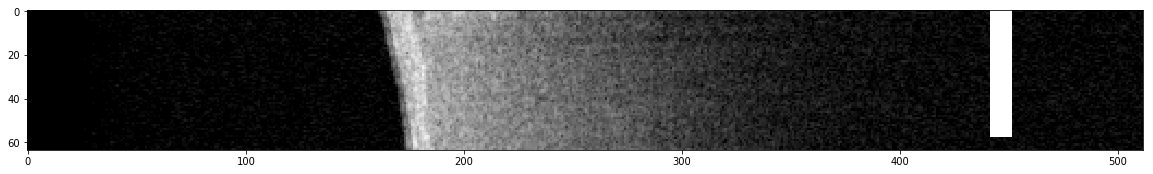

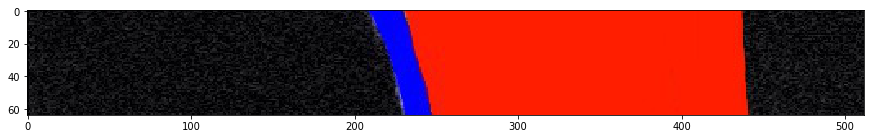

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


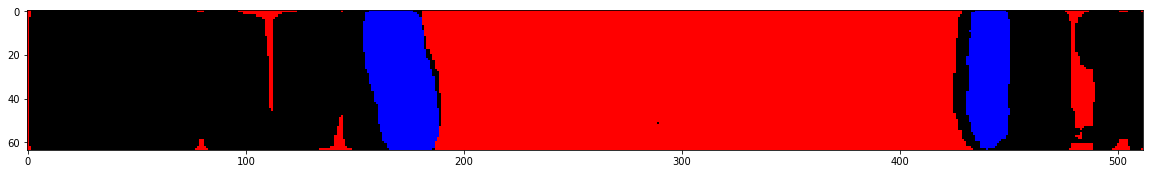

In [94]:
for i in range(15,16):
    ind = i
    
    # Raw Test Image 
    testing_image = train_images[ind]
    testing_image = np.squeeze(testing_image,axis = 2)
    plt.figure(figsize=(20,10))
    plt.imshow(np.rot90(testing_image), cmap=plt.cm.gray)
    
    # Manual Test Image 
    plt.figure(figsize=(15,2))
    plt.imshow(np.rot90(manual_labels[train_indices[37]]))

#     plt.figure(figsize=(20,10))
#     new_train_labels = np.copy(train_labels)
#     new_train_labels = new_train_labels.reshape((validation_cutoff,512,64,8))
#     for i in range(7):
#         plt.imshow(np.rot90(new_train_labels[ind,:,:,i]), alpha=0.5)
    
#     fig, axes = plt.subplots(nrows=1, ncols=7, figsize=(10,10))
#     for i, ax in enumerate(axes):
#         ax.imshow(np.rot90(new_train_labels[ind,:,:,i]))
#         ax.set_title("slice " + str(i))
    plt.show()

    testing_image = testing_image.reshape((1,512,64,1))
    prediction = model.predict(testing_image)
    prediction = np.squeeze(prediction,axis = 0)
#     print(prediction.shape)

    np.argmax(prediction[6999])

    prediction = np.reshape(prediction,(512,64,8))
    output = np.zeros((512,64))
    ground = np.zeros((512,64))
    for i in range(512):
        for j in range(64):
            index = np.argmax(prediction[i][j])
            output[i][j] = index
    test_labels[0].shape

    # test_labels[20][6999]

    test_ground_truth = np.reshape(train_labels[ind],(512,64,8))
    for i in range(512):
        for j in range(64):
            index = np.argmax(test_ground_truth[i][j])
            ground[i][j] = index
    for i in range(512):
        for j in range(64):
            index = np.argmax(prediction[i][j])
            output[i][j] = index
#     print (output.shape)

    color= np.zeros((512,64,3))
    c0 = 0
    c1 = 0
    c2 = 0
    c3 = 0
    c4 = 0
    c5 = 0
    c6 = 0
    c7 = 0
    for j in range(512):
        for k in range(64):
            if(output[j][k]==0):
                c0 = c0 + 1
                color[j][k] = [0,0,0]
            if(output[j][k]==1):
                c1 = c1 + 1
                color[j][k] = [255,0,0]
            if(output[j][k]==2):
                c2 = c2 + 1
                color[j][k] = [0, 0, 255]
            if(output[j][k]==3):
                c3 = c3 + 1
                color[j][k] = [177,10,255] 
            if(output[j][k]==4):
                c4 = c4 + 1
                color[j][k] = [0,255,0]
            if(output[j][k]==5):
                c5 = c5 + 1
                color[j][k] = [255, 140, 0]
            if(output[j][k]==6):
                c6 = c6 + 1
                color[j][k] = [255, 255, 0]
            if(output[j][k]==7):
                c7 = c7 + 1
                color[j][k] = [255,0,255]

#     print('index 0:', c0)
#     print('index 1:', c1)
#     print('index 2:', c2)
#     print('index 3:', c3)
#     print('index 4:', c4)
#     print('index 5:', c5)
#     print('index 6:', c6)
#     print('index 7:', c7)

    %matplotlib inline
    plt.figure(figsize=(20,10))
    plt.imshow(np.rot90(color))